# Section 1: Project Definition

## Project Overview : analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population.

## Problem Statement : What is user is more likely  to be Arvato Financial Services customer 

In [19]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import Imputer ,StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
# magic word for producing visualizations in notebook
%matplotlib inline

## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

In [20]:
# load in the data
azdias = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_AZDIAS_052018.csv', sep=';')
customers = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_CUSTOMERS_052018.csv', sep=';')

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


# Section 2: Analysis

## Data Exploration

In [21]:
def dataExploring(df):
    ''' 
    INPUT: 
        df : dataframe want to be explored 
    output: 
       number_of_missing_values : DataFrame of each column and it number of missing value 
       number_of_unique_values  : DataFrame of each column and it number of unique value 
    
    Description: Provide insight about  dataframe  features and  descriptive statistics 
    '''
    # dataframe shape
    print('number of Features is ',df.shape[1])
    print('number of rows is ',df.shape[0])
    print('----------------')
    
    print('number of record having missing data more then 50%' , df[df.isna().sum(axis=1)>0.50*df.shape[1]].shape[0])
    # column with missing data above 75%
    print('column with missing data above 65%' )
    missin_column_more_75 = df.columns[df.isna().sum()>0.65*df.shape[0]].values
    print(missin_column_more_75)
    print('-----------------')
    
    
    # Number of duplicate records 
    print('Number of duplicate records is ',df.duplicated().sum(axis=0))
    print('----------------')
    # column data type
    print('column data type is ')
    print(df.get_dtype_counts())
    
    
    # create dataFrame for each colmun and number of missing values 
    number_of_missing_values = pd.DataFrame(index=['column name'],columns=['number of missing value'])
    for col in df.columns:
        number_of_missing_values.loc[col]=[df[col].isna().sum()]
    number_of_missing_values.sort_values(by='number of missing value',ascending=False ,inplace=True)
    
    number_of_unique_values = pd.DataFrame(index=['column name'],columns=['number of unique value'])
    for col in df.columns:
        number_of_unique_values.loc[col]=[df[col].nunique()]
    number_of_unique_values.sort_values(by='number of unique value',ascending=False ,inplace=True)
    
    return number_of_missing_values , number_of_unique_values
    
    
    
number_of_missing_values , number_of_unique_values = dataExploring(azdias)

number of Features is  366
number of rows is  891221
----------------
number of record having missing data more then 50% 99231
column with missing data above 65%
['ALTER_KIND1' 'ALTER_KIND2' 'ALTER_KIND3' 'ALTER_KIND4' 'EXTSEL992'
 'KK_KUNDENTYP']
-----------------
Number of duplicate records is  0
----------------
column data type is 
float64    267
int64       93
object       6
dtype: int64


In [22]:
def describe_DataFrame(df):
    #  dataFrame statistics 
    print(df.describe())
describe_DataFrame(azdias)

                LNR       AGER_TYP     AKT_DAT_KL       ALTER_HH  \
count  8.912210e+05  891221.000000  817722.000000  817722.000000   
mean   6.372630e+05      -0.358435       4.421928      10.864126   
std    2.572735e+05       1.198724       3.638805       7.639683   
min    1.916530e+05      -1.000000       1.000000       0.000000   
25%    4.144580e+05      -1.000000       1.000000       0.000000   
50%    6.372630e+05      -1.000000       3.000000      13.000000   
75%    8.600680e+05      -1.000000       9.000000      17.000000   
max    1.082873e+06       3.000000       9.000000      21.000000   

        ALTER_KIND1   ALTER_KIND2  ALTER_KIND3  ALTER_KIND4  \
count  81058.000000  29499.000000  6170.000000  1205.000000   
mean      11.745392     13.402658    14.476013    15.089627   
std        4.097660      3.243300     2.712427     2.452932   
min        2.000000      2.000000     4.000000     7.000000   
25%        8.000000     11.000000    13.000000    14.000000   
50%      

In [23]:
def df_values(df):
    # DataFrame values counts
    for column in df.columns:
        print(df[column].value_counts())
df_values(azdias)

192418     1
611455     1
982154     1
976009     1
978056     1
955527     1
957574     1
951429     1
953476     1
963715     1
965762     1
959617     1
961664     1
613502     1
1021095    1
607357     1
609404     1
619643     1
621690     1
615545     1
617592     1
595063     1
597110     1
590965     1
593012     1
603251     1
980107     1
969868     1
967821     1
973966     1
          ..
626587     1
624538     1
581553     1
577459     1
735180     1
587700     1
724939     1
722890     1
729033     1
726984     1
749511     1
747462     1
753605     1
751556     1
741315     1
739266     1
745409     1
743360     1
569279     1
567230     1
573373     1
571324     1
561083     1
559034     1
565177     1
563128     1
585655     1
583606     1
589749     1
192606     1
Name: LNR, Length: 891221, dtype: int64
-1    677503
 2     98472
 1     79802
 3     27104
 0      8340
Name: AGER_TYP, dtype: int64
1.0    390258
9.0    270663
5.0     29203
6.0     27655
3.0     24880
4.0

In [24]:
number_of_missing_values , number_of_unique_values = dataExploring(customers)

number of Features is  369
number of rows is  191652
----------------
number of record having missing data more then 50% 50751
column with missing data above 65%
['ALTER_KIND1' 'ALTER_KIND2' 'ALTER_KIND3' 'ALTER_KIND4']
-----------------
Number of duplicate records is  0
----------------
column data type is 
float64    267
int64       94
object       8
dtype: int64


In [25]:
describe_DataFrame(customers)

                 LNR       AGER_TYP     AKT_DAT_KL       ALTER_HH  \
count  191652.000000  191652.000000  145056.000000  145056.000000   
mean    95826.500000       0.344359       1.747525      11.352009   
std     55325.311233       1.391672       1.966334       6.275026   
min         1.000000      -1.000000       1.000000       0.000000   
25%     47913.750000      -1.000000       1.000000       8.000000   
50%     95826.500000       0.000000       1.000000      11.000000   
75%    143739.250000       2.000000       1.000000      16.000000   
max    191652.000000       3.000000       9.000000      21.000000   

        ALTER_KIND1  ALTER_KIND2  ALTER_KIND3  ALTER_KIND4  \
count  11766.000000  5100.000000  1275.000000   236.000000   
mean      12.337243    13.672353    14.647059    15.377119   
std        4.006050     3.243335     2.753787     2.307653   
min        2.000000     2.000000     5.000000     8.000000   
25%        9.000000    11.000000    13.000000    14.000000   
50%   

In [26]:
df_values(customers)

2047      1
161124    1
146797    1
144748    1
134507    1
132458    1
138601    1
136552    1
159079    1
157030    1
163173    1
150883    1
38200     1
148834    1
154977    1
152928    1
44351     1
42302     1
48445     1
46396     1
36155     1
34106     1
140654    1
142703    1
185712    1
187761    1
93575     1
91526     1
97669     1
95620     1
         ..
189065    1
191112    1
168583    1
170630    1
164485    1
166532    1
156313    1
160411    1
10960     1
150172    1
53967     1
56014     1
49869     1
51916     1
62155     1
64202     1
58057     1
60104     1
37575     1
39622     1
33477     1
35524     1
45763     1
47810     1
41665     1
43712     1
152223    1
154270    1
148125    1
2049      1
Name: LNR, Length: 191652, dtype: int64
-1    92107
 2    45874
 1    40382
 3     8658
 0     4631
Name: AGER_TYP, dtype: int64
1.0    119535
2.0      6214
9.0      5981
5.0      4096
3.0      2516
4.0      2311
7.0      1649
6.0      1575
8.0      1179
Name: AKT_DAT

## Data Visualization

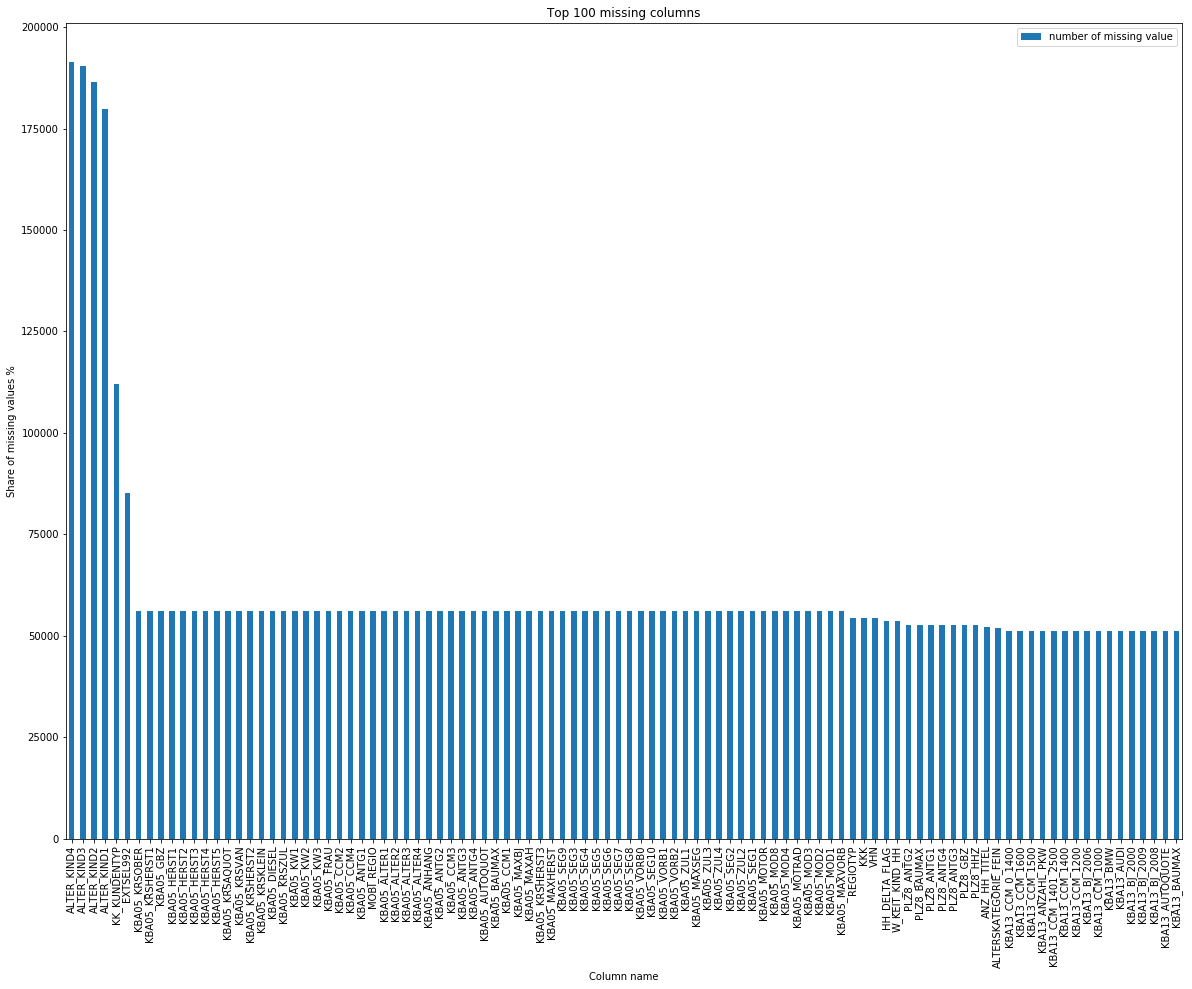

In [27]:
# Visualize number of missing value for each column 
ax = number_of_missing_values.head(100).plot(kind='bar', figsize=(20,15), title='Top 100 missing columns')
ax.set_xlabel("Column name")
ax.set_ylabel("Share of missing values %")
ax.figure.savefig('top_missing.png', dpi=500);

number of unique data in column 
                             number of unique value
LNR                                         191652
EINGEFUEGT_AM                                 3034
KBA13_ANZAHL_PKW                              1250
ANZ_HAUSHALTE_AKTIV                            216
ANZ_STATISTISCHE_HAUSHALTE                     214
GEBURTSJAHR                                    113
EXTSEL992                                       56
VERDICHTUNGSRAUM                                46
CAMEO_DEU_2015                                  45
CAMEO_INTL_2015                                 43
LP_LEBENSPHASE_FEIN                             41
D19_LETZTER_KAUF_BRANCHE                        35
EINGEZOGENAM_HH_JAHR                            33
MIN_GEBAEUDEJAHR                                32
ALTERSKATEGORIE_FEIN                            25
ALTER_HH                                        21
ANZ_HH_TITEL                                    20
CAMEO_DEUG_2015                                 

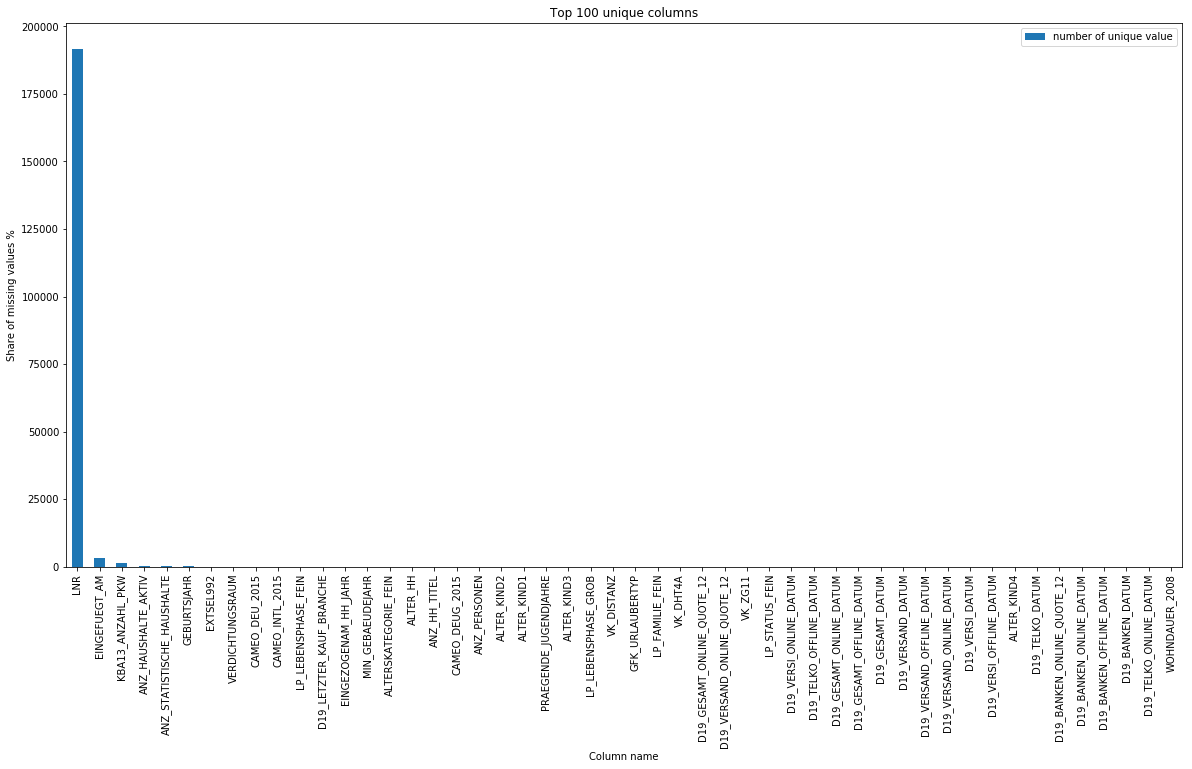

In [28]:
# Visualize number of unique value for each column 
ax = number_of_unique_values.head(50).plot(kind='bar', figsize=(20,10), title='Top 100 unique columns')
ax.set_xlabel("Column name")
ax.set_ylabel("Share of missing values %")
ax.figure.savefig('top_missing.png', dpi=500);


print('number of unique data in column','\n' , number_of_unique_values )

In [29]:
number_of_missing_values , number_of_unique_values = dataExploring(customers)

number of Features is  369
number of rows is  191652
----------------
number of record having missing data more then 50% 50751
column with missing data above 65%
['ALTER_KIND1' 'ALTER_KIND2' 'ALTER_KIND3' 'ALTER_KIND4']
-----------------
Number of duplicate records is  0
----------------
column data type is 
float64    267
int64       94
object       8
dtype: int64


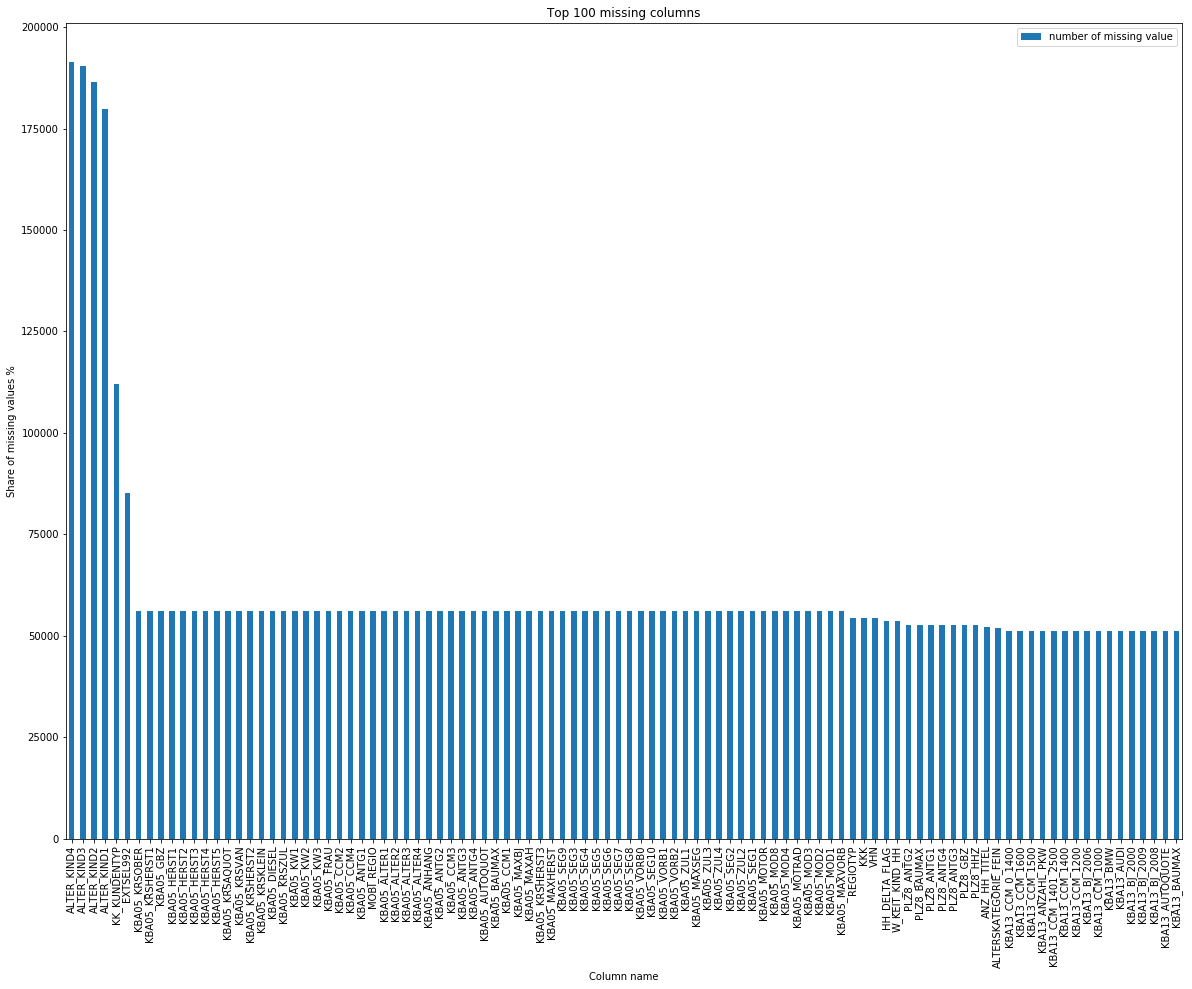

In [30]:
# Visualize number of missing value for each column 
ax = number_of_missing_values.head(100).plot(kind='bar', figsize=(20,15), title='Top 100 missing columns')
ax.set_xlabel("Column name")
ax.set_ylabel("Share of missing values %")
ax.figure.savefig('top_missing.png', dpi=500);

number of unique data in column 
                             number of unique value
LNR                                         191652
EINGEFUEGT_AM                                 3034
KBA13_ANZAHL_PKW                              1250
ANZ_HAUSHALTE_AKTIV                            216
ANZ_STATISTISCHE_HAUSHALTE                     214
GEBURTSJAHR                                    113
EXTSEL992                                       56
VERDICHTUNGSRAUM                                46
CAMEO_DEU_2015                                  45
CAMEO_INTL_2015                                 43
LP_LEBENSPHASE_FEIN                             41
D19_LETZTER_KAUF_BRANCHE                        35
EINGEZOGENAM_HH_JAHR                            33
MIN_GEBAEUDEJAHR                                32
ALTERSKATEGORIE_FEIN                            25
ALTER_HH                                        21
ANZ_HH_TITEL                                    20
CAMEO_DEUG_2015                                 

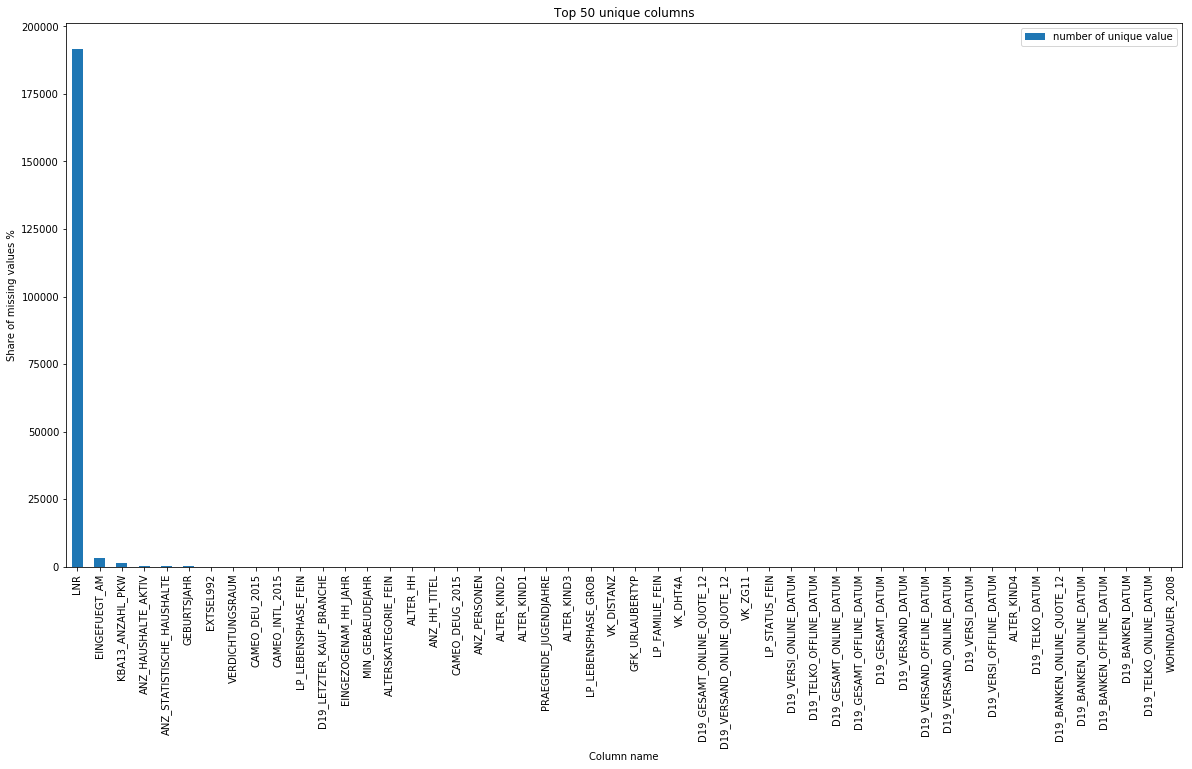

In [31]:
# Visualize number of unique value for each column 
ax = number_of_unique_values.head(50).plot(kind='bar', figsize=(20,10), title='Top 50 unique columns')
ax.set_xlabel("Column name")
ax.set_ylabel("Share of missing values %")
ax.figure.savefig('top_missing.png', dpi=500);


print('number of unique data in column','\n' , number_of_unique_values )

# Section 3: Methodology

# Data Preprocessing

In [32]:
customers.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,PRODUCT_GROUP,CUSTOMER_GROUP,ONLINE_PURCHASE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,9626,2,1.0,10.0,NaN,NaN,NaN,NaN,10.0,1.0,...,2.0,6.0,9.0,7.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,1,4
1,9628,-1,9.0,11.0,NaN,NaN,NaN,NaN,NaN,NaN,...,3.0,0.0,9.0,NaN,3,FOOD,SINGLE_BUYER,0,1,4
2,143872,-1,1.0,6.0,NaN,NaN,NaN,NaN,0.0,1.0,...,11.0,6.0,9.0,2.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,2,4
3,143873,1,1.0,8.0,NaN,NaN,NaN,NaN,8.0,0.0,...,2.0,NaN,9.0,7.0,1,COSMETIC,MULTI_BUYER,0,1,4
4,143874,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,7.0,...,4.0,2.0,9.0,3.0,1,FOOD,MULTI_BUYER,0,1,3


In [33]:

customers.drop(['CUSTOMER_GROUP', 'ONLINE_PURCHASE', 'PRODUCT_GROUP'], inplace=True, axis=1)
# remove rows with more then 16 missing value 
azdias=azdias[azdias.isnull().sum(axis=1) <= 16].reset_index(drop=True)

In [34]:
azdias.isna().sum()

LNR                                0
AGER_TYP                           0
AKT_DAT_KL                         0
ALTER_HH                           0
ALTER_KIND1                   663930
ALTER_KIND2                   708623
ALTER_KIND3                   728003
ALTER_KIND4                   732195
ALTERSKATEGORIE_FEIN          167182
ANZ_HAUSHALTE_AKTIV                0
ANZ_HH_TITEL                    2783
ANZ_KINDER                         0
ANZ_PERSONEN                       0
ANZ_STATISTISCHE_HAUSHALTE         0
ANZ_TITEL                          0
ARBEIT                          2948
BALLRAUM                         418
CAMEO_DEU_2015                  1951
CAMEO_DEUG_2015                 1951
CAMEO_INTL_2015                 1951
CJT_GESAMTTYP                      0
CJT_KATALOGNUTZER                  0
CJT_TYP_1                          0
CJT_TYP_2                          0
CJT_TYP_3                          0
CJT_TYP_4                          0
CJT_TYP_5                          0
C

In [35]:
azdias.columns[azdias.isna().sum()>0.65*azdias.shape[0]].values

array(['ALTER_KIND1', 'ALTER_KIND2', 'ALTER_KIND3', 'ALTER_KIND4',
       'EXTSEL992'], dtype=object)

In [36]:
def Preprocessing(df):
    
    ''' 
    INPUT: 
        df : dataframe want to be cleand 
    output: 
        df : clean dataFrame 
    
    Description: clean dataframe  
    '''
    print('befor cleaning DataFrame shape is' , df.shape)
    

    # remove column with missing values more then 60% of record 
    df_column_deleted = df.columns[df.isna().sum()>=0.65*df.shape[0]].values
    df = df.drop(columns=df_column_deleted)
        
    # remove column with low corrleation 
    corr_matrix = df.corr().abs()
    upper_limit = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
    drop_columns = [column for column in upper_limit.columns if any(upper_limit[column] > .7)]
    df = df.drop(columns=drop_columns)

    
    # fill nan values with -1 
    df[['CAMEO_DEUG_2015','CAMEO_INTL_2015']] = df[['CAMEO_DEUG_2015','CAMEO_INTL_2015']].replace(['X','XX'],-1)
    df[['CAMEO_DEUG_2015','CAMEO_INTL_2015']] = df[['CAMEO_DEUG_2015','CAMEO_INTL_2015']].fillna(-1)
    df[['CAMEO_DEUG_2015','CAMEO_INTL_2015']] = df[['CAMEO_DEUG_2015','CAMEO_INTL_2015']].astype(int)
    df[['CAMEO_DEU_2015','OST_WEST_KZ']]=df[['CAMEO_DEU_2015','OST_WEST_KZ']].fillna(-1)
    
    # drop column with so many unique values
    df = df.drop(columns = ['EINGEFUEGT_AM','KBA13_ANZAHL_PKW'])
    
    # fillna with 9 for fields that has 9 marked as unknown
    df[df.columns[(df==9).any()]] = df[df.columns[(df==9).any()]].fillna(9)

    # fillna with 0 for fields that has 0 marked as unknown
    df[df.columns[(df==0).any()]] = df[df.columns[(df==0).any()]].fillna(0)

    # fillna with -1 for fields that has 0 marked as unknown
    df[df.columns[(df==-1).any()]] = df[df.columns[(df==-1).any()]].fillna(-1)
    # one hot encoding for catgorail values
    df = pd.get_dummies(df)
    df_columns = list(df.columns.values)
    # imput missing values 
    imputer = Imputer(missing_values='NaN',strategy='most_frequent',axis=0)
    df = imputer.fit_transform(df)
    df = pd.DataFrame(df)
    
    df = df.astype(int)

    # remove outlier data 
    df[(np.abs(stats.zscore(df)) < 6).all(axis=1)]
    
    
    standard_scaler = StandardScaler(copy= False)
    scaled = standard_scaler.fit_transform(df)
    df = pd.DataFrame(scaled,columns= df_columns)
    df = df.set_index('LNR')
    print('after cleaning DataFrame shape is' , df.shape)
    return df
        


In [37]:
azdias = Preprocessing(azdias)        
customers = Preprocessing(customers)

befor cleaning DataFrame shape is (733227, 366)
after cleaning DataFrame shape is (733227, 317)
befor cleaning DataFrame shape is (191652, 366)
after cleaning DataFrame shape is (191652, 337)


In [38]:
customers.shape

(191652, 337)

In [39]:
azdias.shape

(733227, 317)

# Implementation

## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

#### Using PCA ( principle component analysis ) the dimension of our datasets will be reduced  To be able to cluster the data 


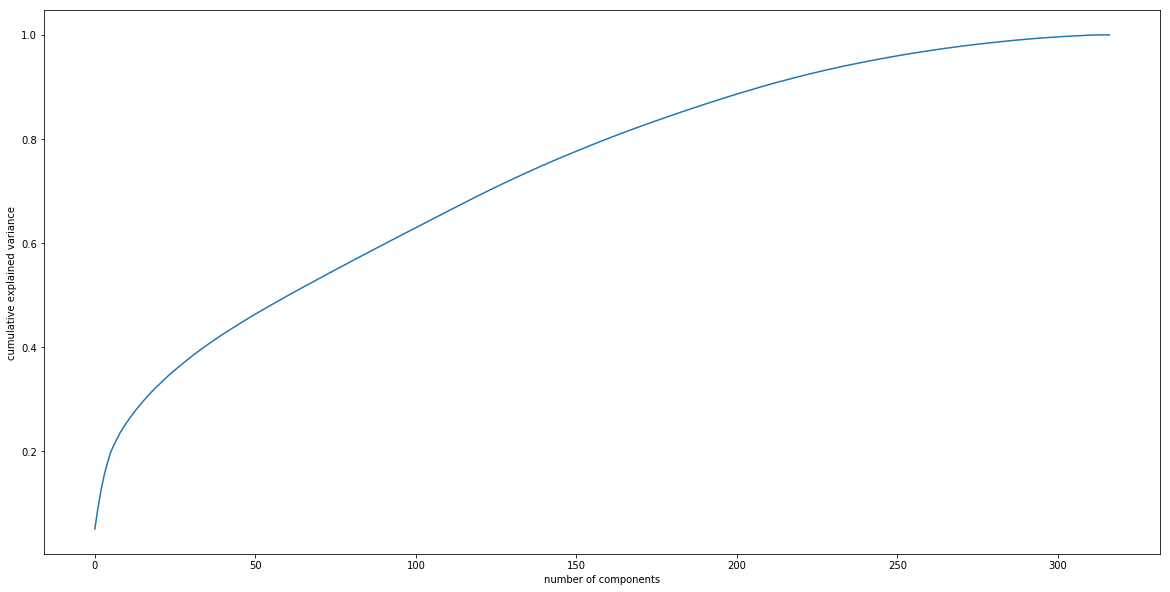

In [40]:
pca = PCA().fit(azdias)
plt.figure(figsize=(20,10))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.show()

as it show in the figure having about 300 component almost have 1 cumulative explained variance

In [41]:
def PCA_dimension(df):
    pca = PCA(n_components=300).fit(df)
    print(pca.explained_variance_ratio_.sum())
    df = pca.transform(df)
    df = pd.DataFrame(df)
    return df
    

In [42]:
customers = PCA_dimension(customers)
azdias = PCA_dimension(azdias)

0.997386354116
0.99584763931


In [43]:
print('customers dim',customers.shape)
print('azdias dim ',azdias.shape)

customers dim (191652, 300)
azdias dim  (733227, 300)


In [44]:
azdias.to_pickle('azdias.pkl')
customers.to_pickle('customers.pkl')

In [45]:
azdias= pd.read_pickle('azdias.pkl')
customers = pd.read_pickle('customers.pkl')

#### After reducing the dimension of data now we are able cluster the data  

#### first we need to determine the number of cluster , we will use Elbow Method to determine number of cluster

([<matplotlib.axis.XTick at 0x7f7d479c69e8>,
 <a list of 19 Text xticklabel objects>)

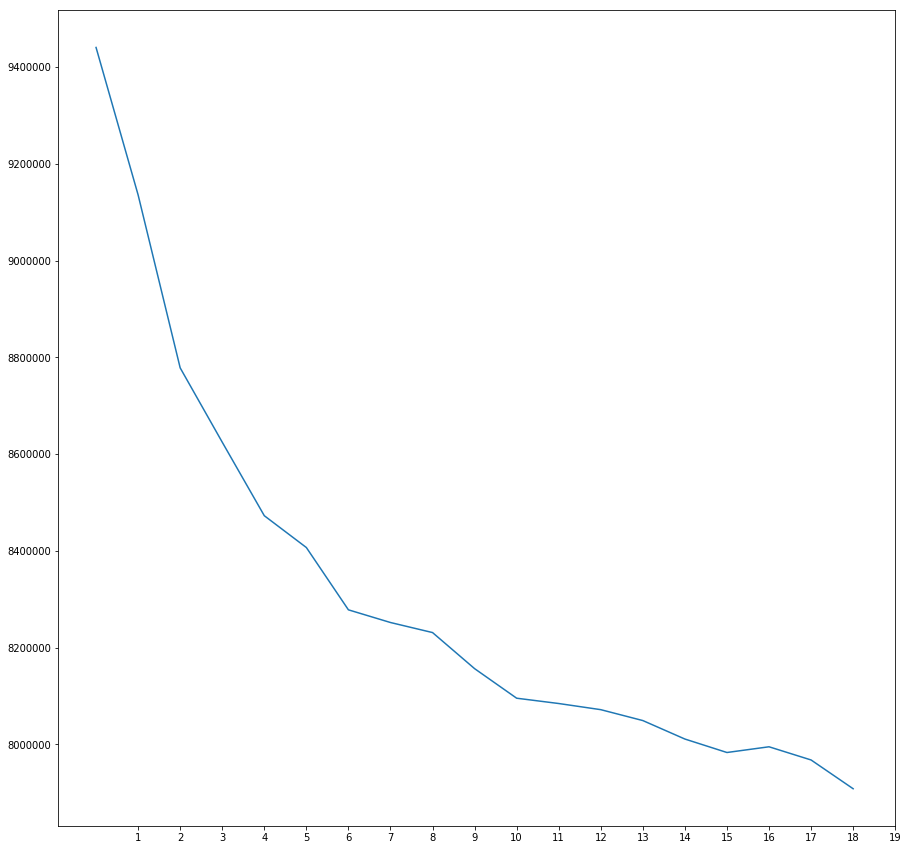

In [46]:
kmeans = [KMeans(n_clusters=i).fit(azdias.sample(30000)) for i in range(1,20)]
scores = [kmeans[i].inertia_ for i in range(len(kmeans))]

plt.figure(1,figsize=(15,15))
plt.plot(scores)
plt.xticks(range(1,20))

#### beasd on Elbow Method  the best number of cluster is 14 

In [47]:
n_cluster = 14
kmean_model = KMeans(n_clusters = n_cluster).fit(azdias)
model_clustered_azdias = kmean_model.predict(azdias)
model_clustered_customers = kmean_model.predict(customers)

clustered_azdias = pd.DataFrame(model_clustered_azdias , columns=['cluster'])
clustered_customers = pd.DataFrame(model_clustered_customers , columns=['cluster'])

In [48]:
cu = pd.Series(model_clustered_customers).value_counts().sort_index()
az = pd.Series(model_clustered_azdias).value_counts().sort_index()
df_cluster = pd.concat([az,cu],axis=1).reset_index()
df_cluster.columns = ['cluster','poubltion' , 'customer']

In [49]:
df_cluster=df_cluster.fillna(0)
df_cluster['Population_percentage'] = (df_cluster['poubltion']/df_cluster['poubltion'].sum()).round(4)*100
df_cluster['Customer_percentage'] = (df_cluster['customer']/df_cluster['customer'].sum()).round(4)*100
df_cluster

,cluster,poubltion,customer,Population_percentage,Customer_percentage
0,0,44164,12184,6.02,6.36
1,1,44142,4910,6.02,2.56
2,2,86510,85,11.80,0.04
3,3,13250,1,1.81,0.00
4,4,53802,3002,7.34,1.57
5,5,81919,3159,11.17,1.65
6,6,24735,117,3.37,0.06
7,7,69269,36785,9.45,19.19
8,8,32810,99,4.47,0.05
9,9,72025,17462,9.82,9.11


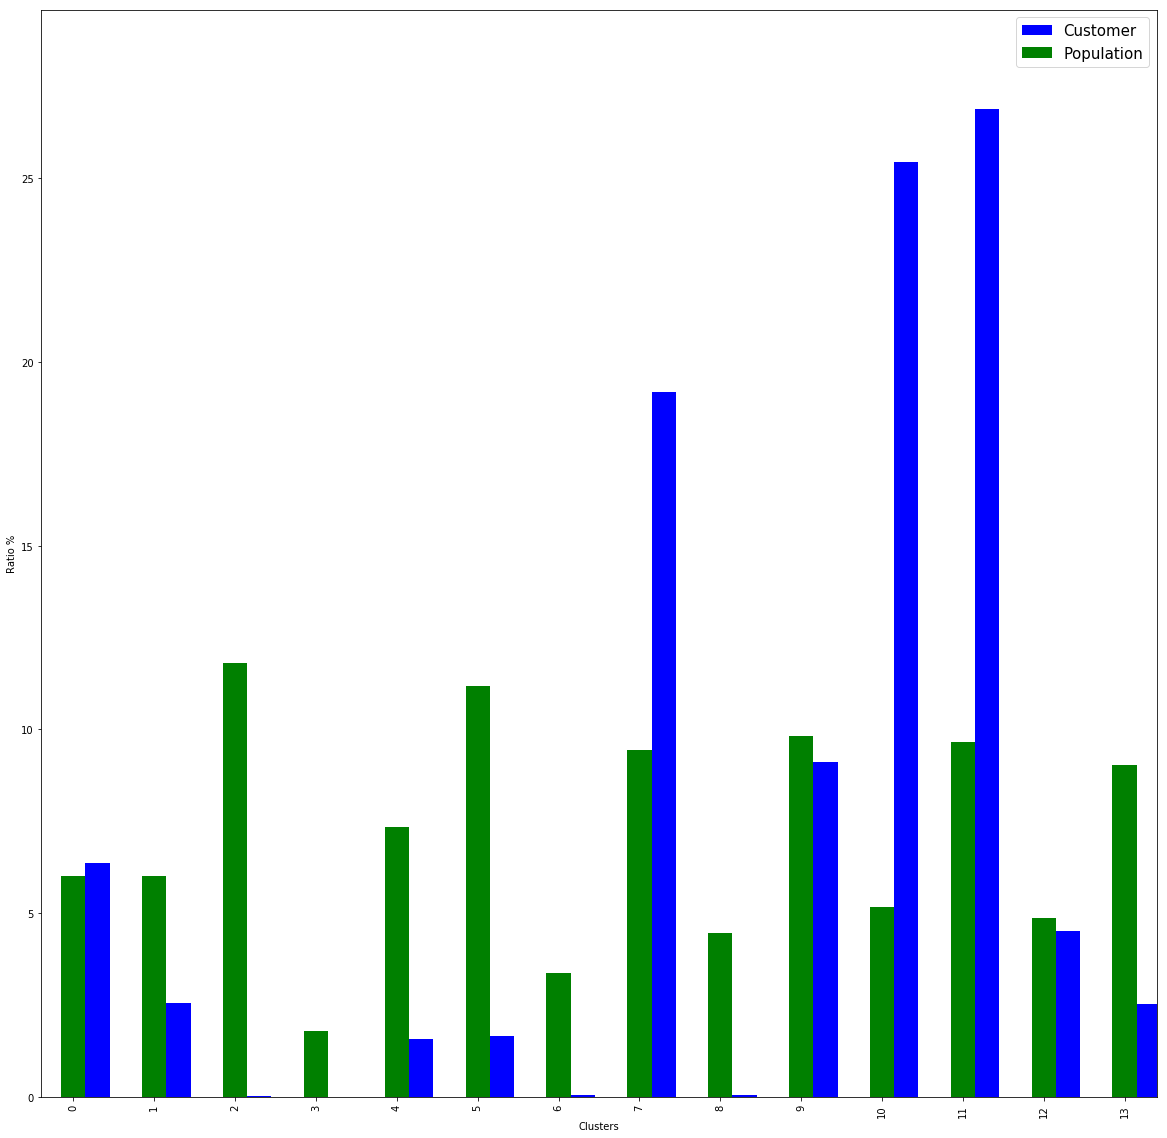

In [50]:
 
fig = plt.figure(1,figsize=(20,20))
ax = fig.add_subplot(111)
ax = df_cluster['Customer_percentage'].plot(x = df_cluster['cluster'] , kind = 'bar' , color = 'blue' ,align='edge',position=0,width = 0.3)
ax = df_cluster['Population_percentage'].plot(x = df_cluster['cluster'] , kind = 'bar' , color = 'green',align='edge',position=1 , width = 0.3)
ax.set_xlabel('Clusters') 
ax.set_ylabel('Ratio %')
ax.margins(x=0.5,y=0.1)
plt.legend(('Customer','Population'),fontsize=15)
plt.show()


##### from general population of Germany that model cluster to  1 , 2 , 7 , 10 are the most likely to be part of the mail-order company's and the least is cluster as 0, 4 , 9 , 13 

## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [51]:
mailout_train = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';')


/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [ ]:
X = mailout_train.drop('RESPONSE',axis=1)
y = mailout_train['RESPONSE']

In [53]:
x=Preprocessing(x)

befor cleaning DataFrame shape is (42962, 366)
after cleaning DataFrame shape is (42962, 334)


In [54]:
trainX , TestX , trsinY  , testY = train_test_split(x,y ,test_size=0.2)

In [55]:
model = xgb.XGBRFRegressor(objective = 'reg:linear' , learning_rate=0.02 , max_depth=5 , alpha=10  )
model.fit(trainX,trsinY)

[13:20:01] WARNING: /tmp/pip-install-6vn1jesi/xgboost/build/temp.linux-x86_64-3.6/xgboost/src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.


XGBRFRegressor(alpha=10, base_score=0.5, booster='gbtree',
        colsample_bylevel=1, colsample_bynode=0.8, colsample_bytree=1,
        enable_categorical=False, gamma=0, gpu_id=-1, importance_type=None,
        interaction_constraints='', learning_rate=0.02, max_delta_step=0,
        max_depth=5, min_child_weight=1, missing=nan,
        monotone_constraints='()', n_estimators=100, n_jobs=1,
        num_parallel_tree=100, objective='reg:linear', predictor='auto',
        random_state=0, reg_alpha=10, reg_lambda=1e-05, scale_pos_weight=1,
        subsample=0.8, tree_method='exact', validate_parameters=1,
        verbosity=None)

In [56]:
Predection  = model.predict(TestX)
model_accuracy = roc_auc_score(testY , Predection)*100
print('model accuracy is {}%'.format(model_accuracy)) 

model accuracy is 50.0%


### Refinement

We will use GridSearchCV to find the best parameter to our model 

In [57]:
model = xgb.XGBRFRegressor()
parameters = { 'learning_rate' : [0.1],
                'n_estimators' :[200],
                'reg_alpha' : [0.05 ,0.10],
                'subsample' : [0.6],
                'max_depth' : [5,10],
                'min_child_weight' : [2],
                'objective' : ['binary:logistic'],
                'random_state' : [42],
                'scoring' : ['roc_auc']
             }
cv = GridSearchCV(model ,parameters)
cv_models = cv.fit(trainX ,trsinY)

[13:20:14] WARNING: /tmp/pip-install-6vn1jesi/xgboost/build/temp.linux-x86_64-3.6/xgboost/src/learner.cc:576: 
Parameters: { "scoring" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[13:21:07] WARNING: /tmp/pip-install-6vn1jesi/xgboost/build/temp.linux-x86_64-3.6/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:21:08] WARNING: /tmp/pip-install-6vn1jesi/xgboost/build/temp.linux-x86_64-3.6/xgboost/src/learner.cc:576: 
Parameters: { "scoring" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then be

In [58]:
best_model = cv_models.best_estimator_
Predict =  best_model.predict(TestX)
model_accuracy = roc_auc_score(testY , Predict)*100
print('model accuracy is {}%'.format(model_accuracy)) 

model accuracy is 77.35120627487603%


##### After using Grid Search to find the best parameters the accuracy of model increase from 50% to 77%  

# Section 4: Results :

let's try to find most import feature from our dataset

['KBA05_MAXSEG' 'KBA05_VORB1' 'KBA13_BJ_2009' 'KBA05_ANTG3' 'KBA05_MAXVORB'
 'KBA13_HERST_EUROPA' 'D19_SOZIALES' 'KBA05_MOD4' 'KBA13_KMH_140_210'
 'KBA05_ANTG1']


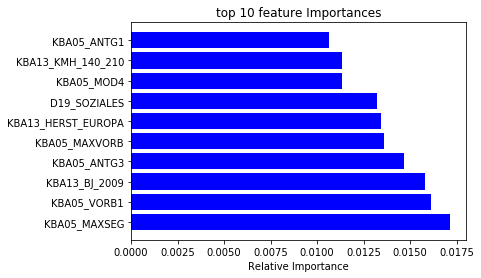

In [61]:
feature_importances = best_model.feature_importances_
most_imortent = 10

indices = np.argsort(feature_importances)[::-1]
columns = trainX.columns.values[indices[:most_imortent]]
values = feature_importances[indices][:most_imortent]

print(columns)

plt.title('top 10 feature Importances')
plt.barh(np.arange(most_imortent), values, color='b', align='center', label = "Feature Weight")


plt.yticks(np.arange(most_imortent), columns)
plt.xlabel('Relative Importance')
plt.show()

